# Analisis Interaksi Siswa Berdasarkan Topik Soal dengan LDA
Notebook ini menyajikan tahapan analisis dari pengumpulan data hingga rekomendasi pembelajaran adaptif berdasarkan pemodelan topik LDA.
Judul "Pembentukan Profil Belajar Siswa Berbasis EdNet Menggunakan LDA dan Analisis Topik Soal"

In [8]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [2]:
# 1. Mount Google Drive (jika file di Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Pengumpulan & Penggabungan Data

In [3]:
import pandas as pd
import zipfile
import os
from tqdm import tqdm
from google.colab import files

# Ekstrak file ZIP
zip_path = "/content/drive/MyDrive/Eksperiment/EdNet-KT1.zip"
extract_path = "KT1_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')][:1000]
    zip_ref.extractall(path=extract_path, members=csv_files)

# Gabungkan data interaksi
interaksi_df_list = []

for file_name in tqdm(csv_files):
    file_path = os.path.join(extract_path, file_name)
    user_id = os.path.splitext(os.path.basename(file_name))[0]

    try:
        df = pd.read_csv(file_path, sep=',')  # <- GANTI ke koma
        df['user_id'] = user_id
        interaksi_df_list.append(df)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

interaksi_df = pd.concat(interaksi_df_list, ignore_index=True)

# Baca questions.csv juga dengan delimiter koma
questions_df = pd.read_csv("/content/drive/MyDrive/Eksperiment/questions.csv", sep=',')

# Cek kolom untuk memastikan
print("Kolom interaksi_df:", interaksi_df.columns.tolist())
print("Kolom questions_df:", questions_df.columns.tolist())

# Gabungkan berdasarkan question_id
gabungan_df = pd.merge(interaksi_df, questions_df, on='question_id', how='left')

# Simpan ke file akhir
# output_filename = "interaksi_soal_gabungan.csv"
output_filename = "combined_question_interaction.csv"
gabungan_df.to_csv(output_filename, index=False)
# files.download(output_filename)


100%|██████████| 1000/1000 [00:01<00:00, 530.89it/s]


Kolom interaksi_df: ['timestamp', 'solving_id', 'question_id', 'user_answer', 'elapsed_time', 'user_id']
Kolom questions_df: ['question_id', 'bundle_id', 'explanation_id', 'correct_answer', 'part', 'tags', 'deployed_at']


In [4]:
# Buka file hasil gabungan
# df = pd.read_csv("interaksi_soal_gabungan.csv")
df = pd.read_csv("combined_question_interaction.csv")

# Tampilkan 5 baris pertama
df.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1535196434651,1,q8098,b,20000,u246317,b5569,e5569,b,1,5;2;182,1514559983093
1,1535196459648,2,q8074,c,22000,u246317,b5545,e5545,c,1,11;7;183,1526633822552
2,1535196482553,3,q176,b,21000,u246317,b176,e176,d,1,6;7;183,1514559223800
3,1564677167247,4,q1279,c,17000,u246317,b1279,e1279,c,2,24;26;182;184,1571281118714
4,1564677196590,5,q6363,d,27000,u246317,b4895,e4895,d,5,130,1558093425874


## Preprocessing (membentuk tag dari tags yang ada pada kolom)


In [5]:
import nltk
from nltk.corpus import stopwords
import re

# Unduh stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

# Baca ulang data
# df = pd.read_csv("interaksi_soal_gabungan.csv")
df = pd.read_csv("combined_question_interaction.csv")

# Ambil data soal unik
soal_df = df[['question_id', 'tags']].drop_duplicates(subset='question_id')

# Perbaiki fungsi tag-to-text
def tags_to_text(tag_str):
    if pd.isna(tag_str):
        return ''
    # Pisahkan berdasarkan koma, spasi, atau titik koma
    tag_list = re.split(r'[,\s;]+', str(tag_str).strip())
    words = [f"tag_{tag}" for tag in tag_list if tag]
    return ' '.join(words)

# Bersihkan dan ubah ke pseudo-text
soal_df['pseudo_text'] = soal_df['tags'].apply(tags_to_text)

# Bersihkan stopwords (walau jarang masuk karena pseudo)
def clean_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

soal_df['pseudo_text'] = soal_df['tags'].apply(tags_to_text)
soal_df['clean_text'] = soal_df['pseudo_text'].apply(clean_text)

# Simpan hasil

soal_text_df = soal_df[['question_id', 'clean_text']]
# soal_text_df.to_csv("soal_pseudo_text.csv", index=False)
soal_text_df.to_csv("pseudotexts_question.csv", index=False)
soal_text_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question_id,clean_text
0,q8098,tag_5 tag_2 tag_182
1,q8074,tag_11 tag_7 tag_183
2,q176,tag_6 tag_7 tag_183
3,q1279,tag_24 tag_26 tag_182 tag_184
4,q6363,tag_130


# **Pseudotext**

In [ ]:
pip install dataframe-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 19.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

# Unduh stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

# Baca data
# df = pd.read_csv("interaksi_soal_gabungan.csv")
df = pd.read_csv("combined_question_interaction.csv")

# Ambil data soal unik
soal_df = df[['question_id', 'tags']].drop_duplicates(subset='question_id')

# Fungsi untuk mengubah tags menjadi pseudo-teks
def tags_to_text(tag_str):
    if pd.isna(tag_str):
        return ''
    tag_list = re.split(r'[,\s;]+', str(tag_str).strip())
    words = [f"tag_{tag}" for tag in tag_list if tag]
    return ' '.join(words)

# Fungsi untuk membersihkan teks dari stopwords
def clean_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# Tambahkan kolom pseudo dan bersihkan
soal_df['Pseudoteks (clean_text)'] = soal_df['tags'].apply(tags_to_text).apply(clean_text)

# Susun ulang kolom sesuai keinginan
soal_text_df = soal_df[['question_id', 'tags', 'Pseudoteks (clean_text)']]

# Simpan ke CSV
# soal_text_df.to_csv("soal_pseudo_text.csv", index=False)
soal_text_df.to_csv("pseudotexts_question.csv", index=False)

# Tampilkan hasil awal
# print(soal_text_df.head())
soal_text_df.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question_id,tags,Pseudoteks (clean_text)
0,q8098,5;2;182,tag_5 tag_2 tag_182
1,q8074,11;7;183,tag_11 tag_7 tag_183
2,q176,6;7;183,tag_6 tag_7 tag_183
3,q1279,24;26;182;184,tag_24 tag_26 tag_182 tag_184
4,q6363,130,tag_130


In [ ]:

import dataframe_image as dfi

# Gunakan matplotlib sebagai engine (hindari Playwright)
dfi.export(soal_text_df.head(), 'soal_pseudo_text_preview.png', table_conversion='matplotlib', dpi=300)

## 2. Representasi Soal (Bag-of-Words)

In [1]:
import pandas as pd
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer

# Baca data soal teks
# soal_text_df = pd.read_csv("soal_pseudo_text.csv")
soal_text_df = pd.read_csv("pseudotexts_question.csv")

# Langkah 1: Tokenisasi teks
soal_text_df['tokens'] = soal_text_df['Pseudoteks (clean_text)'].apply(lambda x: x.split())

# Langkah 2: Buat dictionary dan corpus (gensim format)
dictionary = corpora.Dictionary(soal_text_df['tokens'])

# Filter token yang terlalu jarang/terlalu sering (opsional)
dictionary.filter_extremes(no_below=5, no_above=0.8)

# Corpus: representasi BoW
corpus = [dictionary.doc2bow(text) for text in soal_text_df['tokens']]

# Langkah 3: Validasi Jumlah Dokumen dan Sparsity
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(soal_text_df['tokens'])

num_docs = X.shape[0]
sparsity = 1.0 - X.count_nonzero() / float(X.shape[0] * X.shape[1])

print(f"Jumlah dokumen: {num_docs}")
print(f"Sparsity (tingkat kekosongan): {sparsity:.2%}")
print(f"Jumlah token unik (fitur BoW): {X.shape[1]}")


Jumlah dokumen: 11613
Sparsity (tingkat kekosongan): 98.82%
Jumlah token unik (fitur BoW): 189


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 3. LDA Topic Modeling

In [2]:
from gensim.models import LdaModel, CoherenceModel

# --- Hyperparameter
num_topics = 20
passes = 30  # jumlah pass melalui data

# --- Training LDA
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=passes,
    alpha='auto',
    per_word_topics=True
)

# --- Tampilkan Topik
topik_output = lda_model.print_topics(num_words=10)
for i, topic in enumerate(topik_output):
    print(f"Topic {i}: {topic[1]}")

# --- Hitung Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=soal_text_df['tokens'],
                                     dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"\n✅ Coherence Score: {coherence_score:.4f}")


Topic 0: 0.265*"tag_54" + 0.147*"tag_182" + 0.139*"tag_183" + 0.112*"tag_181" + 0.110*"tag_55" + 0.094*"tag_184" + 0.079*"tag_80" + 0.022*"tag_63" + 0.010*"tag_20" + 0.010*"tag_21"
Topic 1: 0.772*"tag_179" + 0.113*"tag_156" + 0.038*"tag_152" + 0.030*"tag_1" + 0.030*"tag_10" + 0.009*"tag_137" + 0.000*"tag_178" + 0.000*"tag_176" + 0.000*"tag_147" + 0.000*"tag_162"
Topic 2: 0.715*"tag_177" + 0.079*"tag_169" + 0.047*"tag_72" + 0.046*"tag_105" + 0.042*"tag_129" + 0.031*"tag_130" + 0.020*"tag_112" + 0.009*"tag_110" + 0.000*"tag_167" + 0.000*"tag_155"
Topic 3: 0.379*"tag_153" + 0.247*"tag_84" + 0.211*"tag_177" + 0.061*"tag_94" + 0.048*"tag_95" + 0.020*"tag_115" + 0.016*"tag_124" + 0.008*"tag_140" + 0.000*"tag_146" + 0.000*"tag_159"
Topic 4: 0.569*"tag_71" + 0.159*"tag_106" + 0.108*"tag_134" + 0.076*"tag_90" + 0.072*"tag_82" + 0.000*"tag_141" + 0.000*"tag_98" + 0.000*"tag_117" + 0.000*"tag_120" + 0.000*"tag_92"
Topic 5: 0.514*"tag_74" + 0.229*"tag_149" + 0.225*"tag_76" + 0.012*"tag_19" + 0.010

Jumlah Topik: 5, Coherence Score: 0.5870
Jumlah Topik: 10, Coherence Score: 0.5886
Jumlah Topik: 15, Coherence Score: 0.5800
Jumlah Topik: 20, Coherence Score: 0.6688
Jumlah Topik: 25, Coherence Score: 0.6781
Jumlah Topik: 30, Coherence Score: 0.7289


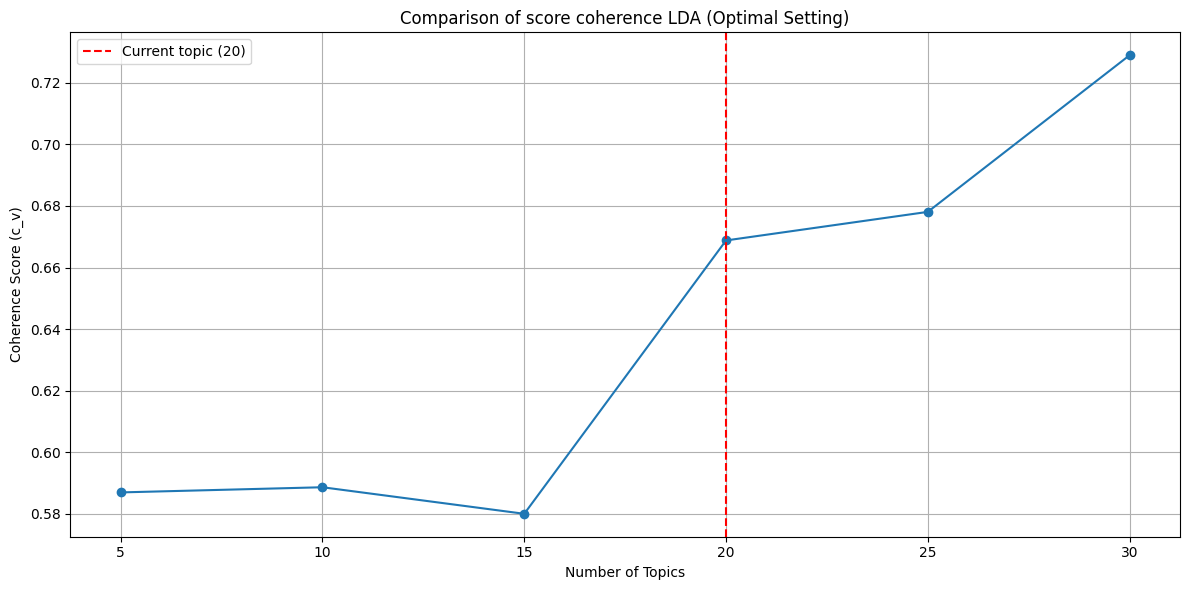

In [3]:
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt

# --- Daftar jumlah topik yang ingin diuji
topic_range = [5, 10, 15, 20, 25, 30]
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=30,
        alpha='auto',
        per_word_topics=True
    )

    coherence_model = CoherenceModel(
        model=lda,
        texts=soal_text_df['tokens'],
        dictionary=dictionary,
        coherence='c_v'
    )

    score = coherence_model.get_coherence()
    coherence_scores.append(score)
    print(f"Jumlah Topik: {num_topics}, Coherence Score: {score:.4f}")

# --- Visualisasi
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.axvline(x=20, linestyle='--', color='red', label='Current topic (20)')
plt.title('Comparison of score coherence LDA (Optimal Setting)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_coherence_lda.png', dpi=300)
plt.show()


## 4. Evaluasi Model Topik

In [6]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.9 MB/s eta 0:00:00


In [7]:
import pyLDAvis
import pyLDAvis.gensim_models

# Siapkan visualisasi
pyLDAvis.enable_notebook()  # untuk notebook interaktif (opsional)

# Buat visualisasi
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Tampilkan di notebook
pyLDAvis.display(vis_data)


In [ ]:
# Download Visualisasi
pyLDAvis.save_html(vis_data, 'lda_visualisasi.html')
from google.colab import files
files.download('lda_visualisasi.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Assign Topik Dominan ke Soal

In [14]:
import numpy as np

# Step 1: Ambil topik dominan dari setiap dokumen di corpus
dominant_topic = []
for i, bow in enumerate(corpus):
    topik = lda_model.get_document_topics(bow)
    topik = sorted(topik, key=lambda x: x[1], reverse=True)
    topik_id = topik[0][0] if topik else None  # topik paling dominan
    dominant_topic.append(topik_id)

# Step 2: Tambahkan ke dataframe soal
soal_text_df['dominant_topic'] = dominant_topic

# Step 3: Simpan hasil ke CSV
# soal_text_df[['question_id', 'topik_dominan']].to_csv("soal_topik.csv", index=False)
soal_text_df[['question_id', 'dominant_topic']].to_csv("topic_question.csv", index=False)

# Tampilkan hasil
soal_text_df[['question_id', 'dominant_topic']].head()


,question_id,dominant_topic
0,q8098,12
1,q8074,14
2,q176,14
3,q1279,17
4,q6363,2


In [16]:
import pandas as pd

# Muat file soal pseudo-teks dan topik dominan
# soal_topik_df = pd.read_csv("soal_pseudo_text.csv")
# topik_df = pd.read_csv("soal_topik.csv")
soal_topik_df = pd.read_csv("pseudotexts_question.csv")
topik_df = pd.read_csv("topic_question.csv")

# Gabungkan kedua dataframe
soal_df_full = soal_topik_df.merge(topik_df, on="question_id", how="left")

# Fungsi untuk membalik tag dari clean_text
def reverse_tags(pseudo_text):
    tags = [tag.replace("tag_", "") for tag in pseudo_text.split()]
    return ", ".join(tags)

# Tambahkan kolom "tags" dan "pseudoteks"
soal_df_full["tags"] = soal_df_full["Pseudoteks (clean_text)"].apply(reverse_tags)
soal_df_full["pseudoteks"] = soal_df_full["Pseudoteks (clean_text)"]

# Ubah topik_dominan menjadi format topik_...
soal_df_full["dominant_topic"] = soal_df_full["dominant_topic"].apply(lambda x: f"topic_{x}")

# Ambil  5 data pertama
tabel_4 = soal_df_full[["question_id", "tags", "pseudoteks", "dominant_topic"]].head().reset_index(drop=True)
tabel_4.index += 1
tabel_4.index.name = "No"

tabel_4

,question_id,tags,pseudoteks,dominant_topic
No,,,,
1,q8098,"5, 2, 182",tag_5 tag_2 tag_182,topic_12
2,q8074,"11, 7, 183",tag_11 tag_7 tag_183,topic_14
3,q176,"6, 7, 183",tag_6 tag_7 tag_183,topic_14
4,q1279,"24, 26, 182, 184",tag_24 tag_26 tag_182 tag_184,topic_17
5,q6363,130,tag_130,topic_2


## 6. Mapping Interaksi Siswa ke Topik

In [20]:
import pandas as pd

# Langkah 1: Load data
# interaksi_df = pd.read_csv("interaksi_soal_gabungan.csv")
# topik_df = pd.read_csv("soal_topik.csv")
interaksi_df = pd.read_csv("combined_question_interaction.csv")
topik_df = pd.read_csv("topic_question.csv")

# Langkah 2: Gabungkan interaksi dengan topik soal
gabungan_df = interaksi_df.merge(topik_df, on='question_id', how='left')

# Langkah 3: Hitung label benar/salah
# Bandingkan user_answer dengan correct_answer
gabungan_df['correct'] = (gabungan_df['user_answer'] == gabungan_df['correct_answer']).astype(int)

# Langkah 4: Buat tabel agregat: user_id × topik × jumlah_benar
pivot_df = gabungan_df.groupby(['user_id', 'dominant_topic'])['correct'].agg(['count', 'sum']).reset_index()
pivot_df.rename(columns={'count': 'number_of_interactions', 'sum': 'correct_number'}, inplace=True)

# Hitung persentase akurasi per topik
pivot_df['accuracy'] = pivot_df['correct_number'] / pivot_df['number_of_interactions']

# Simpan hasil akhir
# pivot_df.to_csv("representasi_topik_siswa.csv", index=False)
pivot_df.to_csv("student_topic_representation.csv", index=False)

# Tampilkan 5 baris pertama
pivot_df.head()


,user_id,dominant_topic,number_of_interactions,correct_number,accuracy
0,u100580,0,2,1,0.5
1,u100580,1,1,1,1.0
2,u100580,2,2,1,0.5
3,u100580,3,2,1,0.5
4,u100580,4,1,0,0.0


## Visualisasi Heatmap

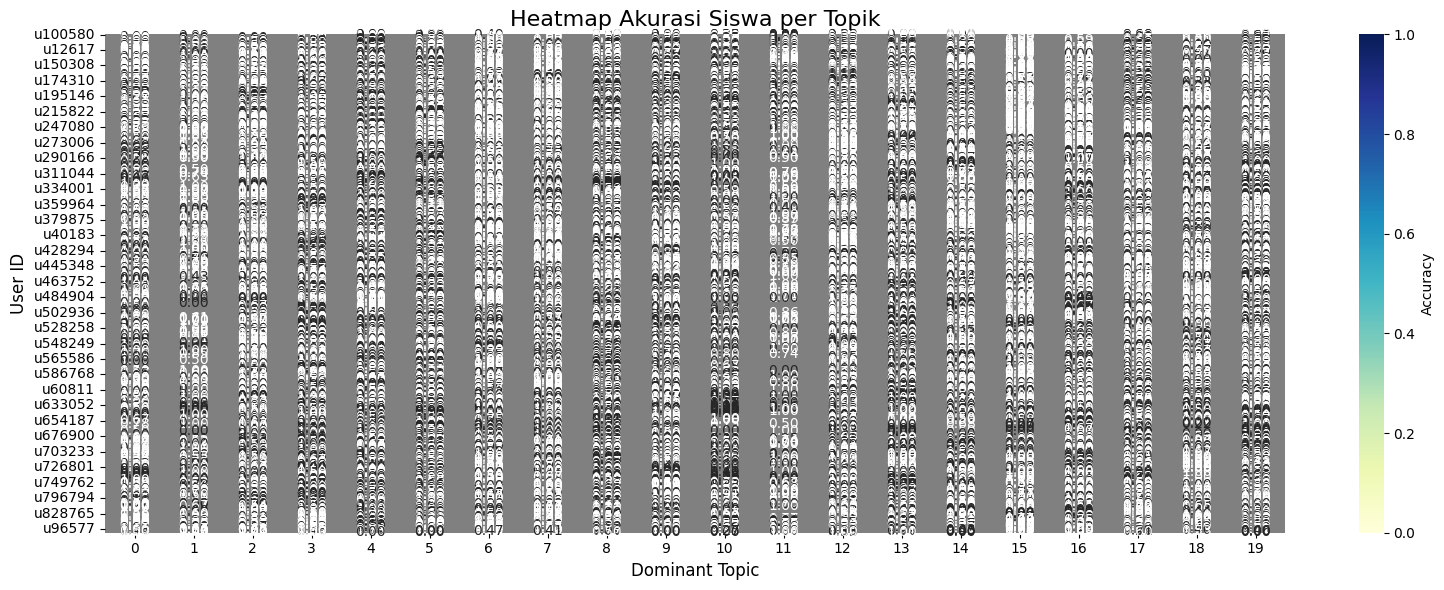

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
# df = pd.read_csv("representasi_topik_siswa.csv")
df = pd.read_csv("student_topic_representation.csv")

# Pivot ke format matriks: user_id × topik → akurasi
pivot = df.pivot(index='user_id', columns='dominant_topic', values='accuracy')

# Sort kolom (topik) agar terurut
pivot = pivot.sort_index(axis=1)

# Atur ukuran
plt.figure(figsize=(16, 6))

# Buat heatmap dengan colormap biru → merah
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Accuracy'})

# Judul dan label
plt.title("Heatmap Akurasi Siswa per Topik", fontsize=16)
plt.xlabel("Dominant Topic", fontsize=12)
plt.ylabel("User ID", fontsize=12)
plt.tight_layout()
plt.show()


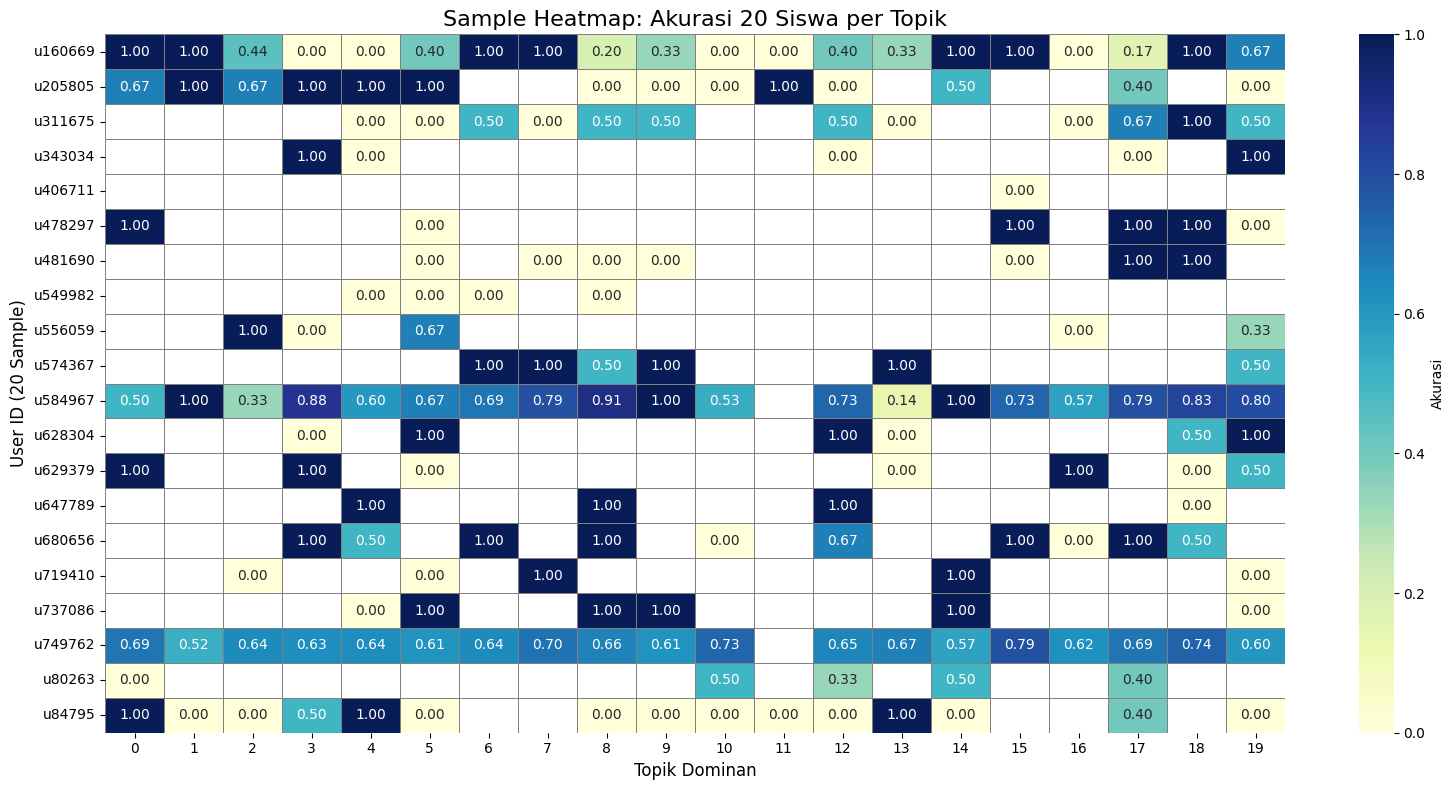

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("representasi_topik_siswa.csv")
df = pd.read_csv("student_topic_representation.csv")

# Pilih 20 user_id secara acak
sample_users = df['user_id'].drop_duplicates().sample(n=20, random_state=42)
df_sample = df[df['user_id'].isin(sample_users)]

# Pivot ke format matriks: user_id × topik → akurasi
pivot_sample = df_sample.pivot(index='user_id', columns='dominant_topic', values='accuracy')
pivot_sample = pivot_sample.sort_index(axis=1)  # urutkan topik

# Tampilkan heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_sample, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Akurasi'})

# Tambahkan judul dan label
plt.title("Sample Heatmap: Akurasi 20 Siswa per Topik", fontsize=16)
plt.xlabel("Topik Dominan", fontsize=12)
plt.ylabel("User ID (20 Sample)", fontsize=12)
plt.tight_layout()
plt.show()


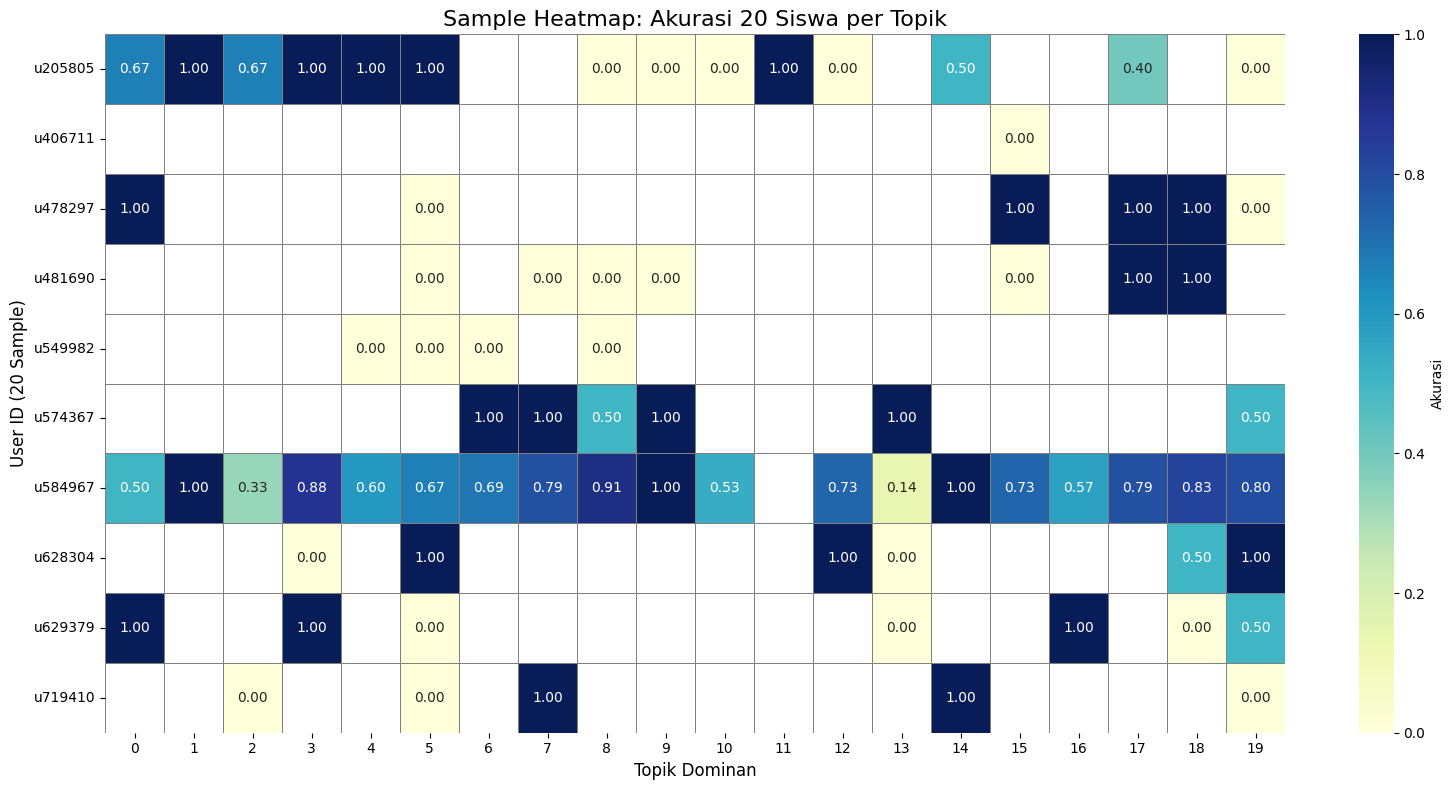

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("representasi_topik_siswa.csv")
df = pd.read_csv("student_topic_representation.csv")

# Pilih 20 user_id secara acak
sample_users = df['user_id'].drop_duplicates().sample(n=10, random_state=42)
df_sample = df[df['user_id'].isin(sample_users)]

# Pivot ke format matriks: user_id × topik → akurasi
pivot_sample = df_sample.pivot(index='user_id', columns='dominant_topic', values='accuracy')
pivot_sample = pivot_sample.sort_index(axis=1)  # urutkan topik

# Tampilkan heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_sample, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Akurasi'})

# Tambahkan judul dan label
plt.title("Sample Heatmap: Akurasi 20 Siswa per Topik", fontsize=16)
plt.xlabel("Topik Dominan", fontsize=12)
plt.ylabel("User ID (20 Sample)", fontsize=12)
plt.tight_layout()
plt.show()


## 7. Perhitungan Performa Siswa per Topik

In [23]:
import pandas as pd

# Load data mapping
# df = pd.read_csv("representasi_topik_siswa.csv")
df = pd.read_csv("student_topic_representation.csv")

# Buat pivot table: user_id × topik_dominan → akurasi
nilai_matrix = df.pivot(index='user_id', columns='dominant_topic', values='accuracy')

# Opsional: isi NaN dengan -1 (atau 0 jika dianggap "belum dikerjakan")
nilai_matrix_filled = nilai_matrix.fillna(-1)  # bisa juga .fillna(0)

# Simpan hasil matriks
# nilai_matrix.to_csv("matriks_nilai_siswa_topik.csv")
nilai_matrix.to_csv("student_grade_matrix_topic.csv")

# Tampilkan 5 baris contoh
nilai_matrix.head()


dominant_topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,,,,,,,,,,,,,,,,,,,,
u100580,0.5,1.0,0.5,0.5,0.0,0.0,0.4,NaN,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,1.0,NaN,0.000000,NaN,0.000000
u101409,0.5,1.0,1.0,0.5,0.0,1.0,NaN,NaN,0.5,0.0,0.250000,0.0,0.333333,1.0,0.5,NaN,NaN,0.400000,NaN,0.500000
u102852,0.5,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.5,1.0,0.500000,0.0,0.333333,1.0,0.0,NaN,NaN,0.600000,NaN,0.000000
u106217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.5,NaN,NaN,NaN,NaN,NaN
u106643,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.800000,0.0,0.625000,1.0,0.0,1.0,NaN,0.666667,0.5,0.666667


In [24]:
# Hitung jumlah topik yang dikerjakan tiap siswa (bukan NaN)
jumlah_topik_terisi = nilai_matrix.notna().sum(axis=1)

# Persentase siswa dengan >5 topik
prop = (jumlah_topik_terisi > 5).mean()

print(f"✅ {prop*100:.2f}% siswa memiliki performa pada lebih dari 5 topik.")


✅ 66.00% siswa memiliki performa pada lebih dari 5 topik.


## Visualisasi distribusi Jumlah Topik

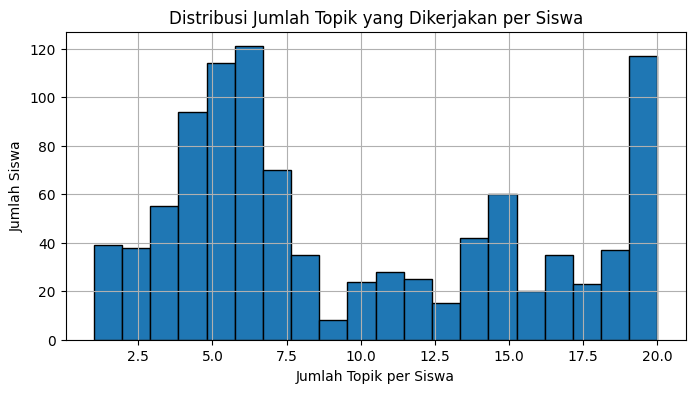

In [25]:
import matplotlib.pyplot as plt

jumlah_topik_terisi.plot.hist(bins=20, edgecolor='black', figsize=(8,4))
plt.title("Distribusi Jumlah Topik yang Dikerjakan per Siswa")
plt.xlabel("Jumlah Topik per Siswa")
plt.ylabel("Jumlah Siswa")
plt.grid(True)
plt.show()


## 8. Bangun Matriks Siswa × Topik

In [27]:
import pandas as pd

# Load data performa siswa per topik
# df = pd.read_csv("representasi_topik_siswa.csv")
df = pd.read_csv("student_topic_representation.csv")

# Pivot data ke matriks: user_id × topik_dominan → akurasi
matriks = pd.pivot_table(df,
                         index='user_id',
                         columns='dominant_topic',
                         values='accuracy')

# Rename kolom agar jelas (opsional)
matriks.columns = [f"topic_{int(c)}" for c in matriks.columns]

# Simpan ke file
# matriks.to_csv("matriks_user_topik.csv")
matriks.to_csv("user_topic_matrix.csv")

# Tampilkan ringkasan
print(f"✅ Matriks siswa-topik terbentuk dengan shape: {matriks.shape}")
print("Jumlah nilai NaN per kolom:")
print(matriks.isna().sum())

# Tampilkan 5 baris pertama
matriks.head()


✅ Matriks siswa-topik terbentuk dengan shape: (1000, 20)
Jumlah nilai NaN per kolom:
topic_0     577
topic_1     690
topic_2     540
topic_3     449
topic_4     411
topic_5     230
topic_6     607
topic_7     635
topic_8     309
topic_9     452
topic_10    604
topic_11    734
topic_12    416
topic_13    558
topic_14    487
topic_15    640
topic_16    548
topic_17    413
topic_18    633
topic_19    370
dtype: int64


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
user_id,,,,,,,,,,,,,,,,,,,,
u100580,0.5,1.0,0.5,0.5,0.0,0.0,0.4,NaN,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,1.0,NaN,0.000000,NaN,0.000000
u101409,0.5,1.0,1.0,0.5,0.0,1.0,NaN,NaN,0.5,0.0,0.250000,0.0,0.333333,1.0,0.5,NaN,NaN,0.400000,NaN,0.500000
u102852,0.5,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.5,1.0,0.500000,0.0,0.333333,1.0,0.0,NaN,NaN,0.600000,NaN,0.000000
u106217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.5,NaN,NaN,NaN,NaN,NaN
u106643,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.800000,0.0,0.625000,1.0,0.0,1.0,NaN,0.666667,0.5,0.666667


## **Clustering Siswa Berdasarkan Performa Topik**

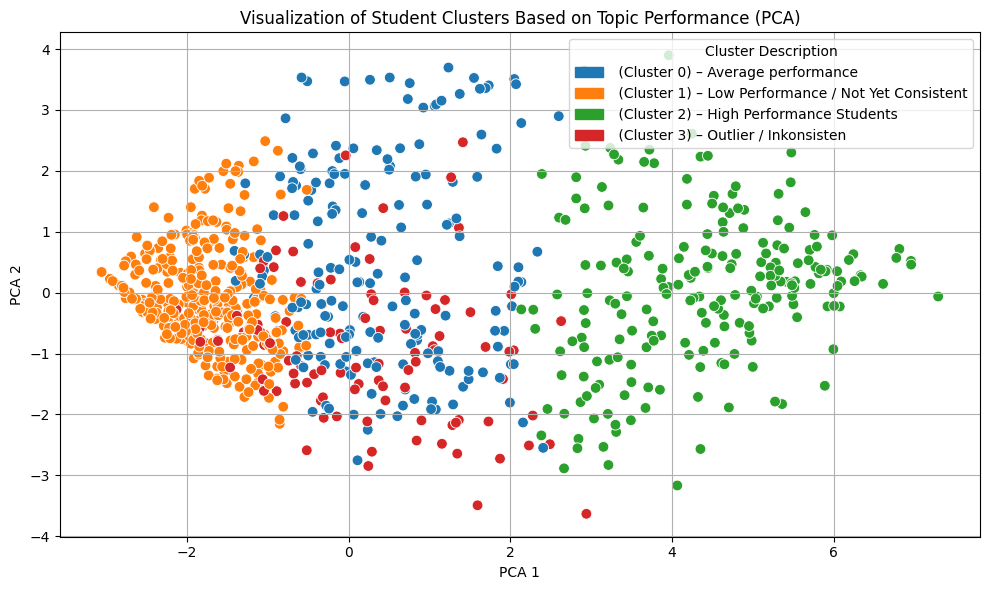

In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load matriks siswa-topik
# matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)
matriks = pd.read_csv("user_topic_matrix.csv", index_col=0)

# Optional: isi NaN dengan 0 atau nilai rata-rata
X = matriks.fillna(0)

# Normalisasi (fitur: topik)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering: tentukan jumlah klaster (misal 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Tambahkan cluster ke DataFrame
X['cluster'] = clusters

# Simpan hasil clustering
# X.to_csv("siswa_topik_cluster.csv")
X.to_csv("student_topic_cluster.csv")

# PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

# Plot visualisasi cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)

plt.title("Visualization of Student Clusters Based on Topic Performance (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

# Tambahkan legend manual untuk interpretasi warna
legend_labels = {
    0: ("", "Average performance"),
    1: ("", "Low Performance / Not Yet Consistent"),
    2: ("", "High Performance Students"),
    3: ("", "Outlier / Inkonsisten"),
}

custom_patches = [
    mpatches.Patch(color=sns.color_palette('tab10')[i], label=f"{v[0]} (Cluster {i}) – {v[1]}")
    for i, v in legend_labels.items()
]

plt.legend(handles=custom_patches, title="Cluster Description", loc='best')
plt.tight_layout()
plt.savefig("PCA_Clustering.png", dpi=300)
plt.show()


In [29]:
from scipy.stats import f_oneway

# Tambahkan kolom skor rata-rata per siswa
X['avg_score'] = X.drop(columns=['cluster', 'pca1', 'pca2']).mean(axis=1)

# Kelompokkan berdasarkan cluster
groups = [group['avg_score'].values for _, group in X.groupby('cluster')]

# Uji ANOVA satu arah
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")


F-statistic: 2475.3318, p-value: 0.0000


In [30]:
# Ambil kembali data original (tanpa PCA)
data_cluster = X.drop(columns=['pca1', 'pca2'])

# Hitung rata-rata akurasi per topik per cluster
cluster_stats = data_cluster.groupby('cluster').mean()

# Tambahkan ukuran cluster
cluster_stats['jumlah_siswa'] = data_cluster['cluster'].value_counts().sort_index()

# Tampilkan ringkasan
cluster_stats.T


cluster,0,1,2,3
topic_0,0.291628,0.067199,0.632985,0.170187
topic_1,0.299935,0.008982,0.636210,0.041943
topic_2,0.381665,0.071357,0.628127,0.275990
topic_3,0.493791,0.075848,0.627342,0.242409
topic_4,0.296379,0.162009,0.604571,0.305882
topic_5,0.348779,0.252462,0.634525,0.509846
topic_6,0.238030,0.085496,0.641779,0.202475
topic_7,0.193422,0.063540,0.636270,0.154290
topic_8,0.360384,0.133965,0.595462,0.407376
topic_9,0.240890,0.143879,0.630249,0.247501


## 9. Visualisasi Profil Belajar Siswa

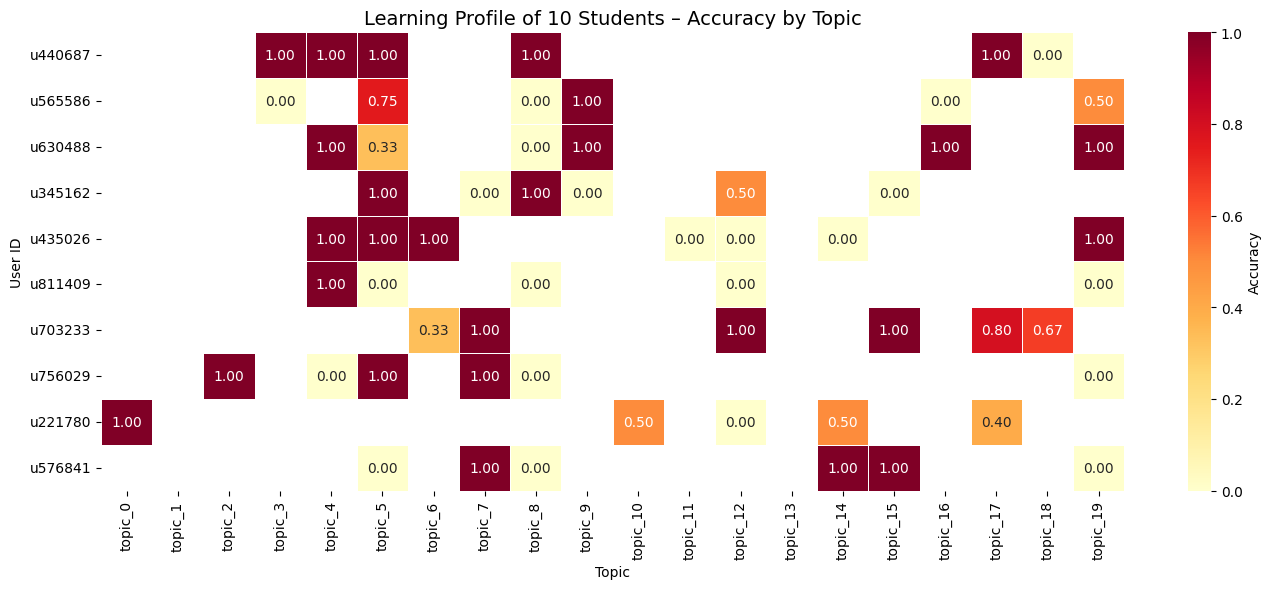

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matriks siswa × topik
# matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)
matriks = pd.read_csv("user_topic_matrix.csv", index_col=0)

# Pilih 10 siswa secara acak atau berdasarkan interaksi banyak
top10 = matriks.dropna(thresh=5).sample(10, random_state=42)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(top10, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Accuracy'})
plt.title("Learning Profile of 10 Students – Accuracy by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("User ID")
plt.tight_layout()
plt.savefig("Heatmap_Learning_Profile.png", dpi=300)
plt.show()


<ipython-input-33-2507761366>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])


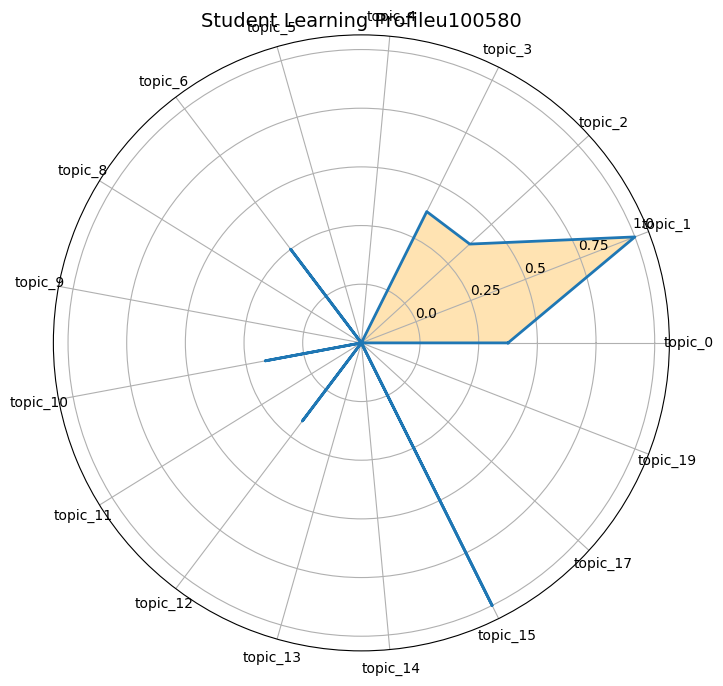

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Pilih 1 siswa
user_id = 'u100580'
row = matriks.loc[user_id].dropna()

labels = row.index.tolist()
values = row.values.tolist()
values += values[:1]  # ulang titik pertama untuk menutup lingkaran

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, color='orange', alpha=0.3)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_title(f"Student Learning Profile{user_id}", fontsize=14)
plt.show()


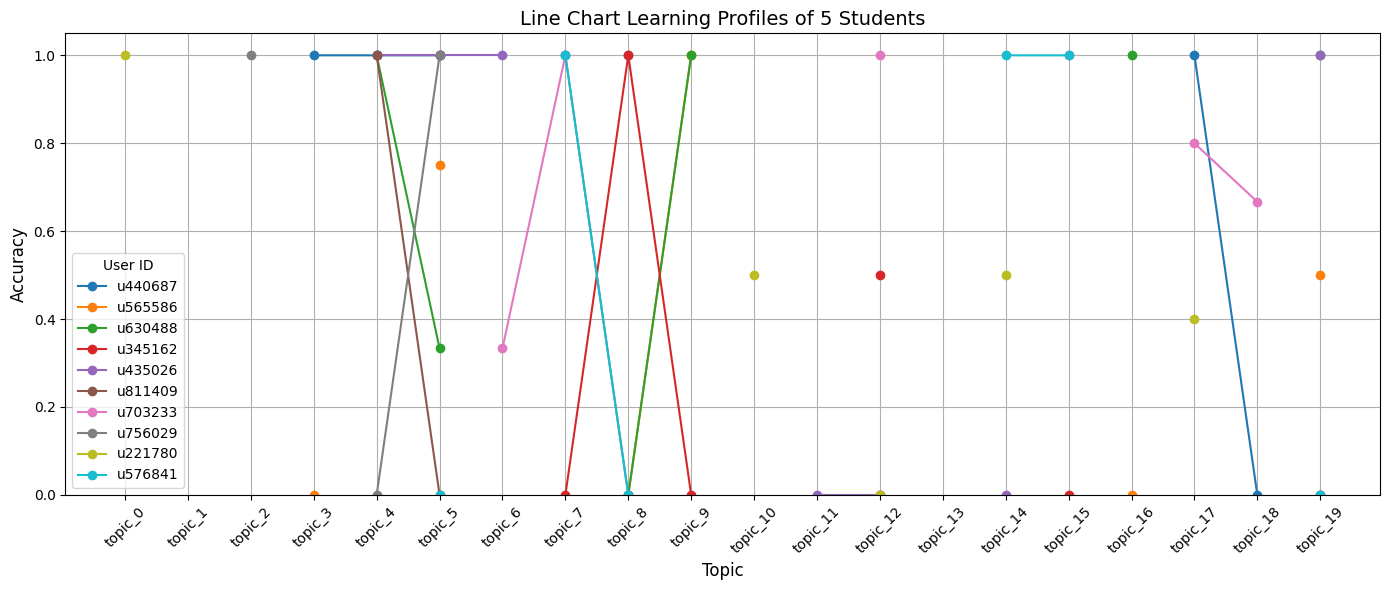

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load matriks user-topik
# matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)
matriks = pd.read_csv("user_topic_matrix.csv", index_col=0)

# Pilih 5 siswa acak dengan data cukup
sample_users = matriks.dropna(thresh=5).sample(10, random_state=42)

# Plot line chart
plt.figure(figsize=(14, 6))

for user_id, row in sample_users.iterrows():
    plt.plot(row.index, row.values, marker='o', label=user_id)

# Kustomisasi
plt.title("Line Chart Learning Profiles of 5 Students", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title="User ID")
plt.grid(True)
plt.tight_layout()
plt.show()


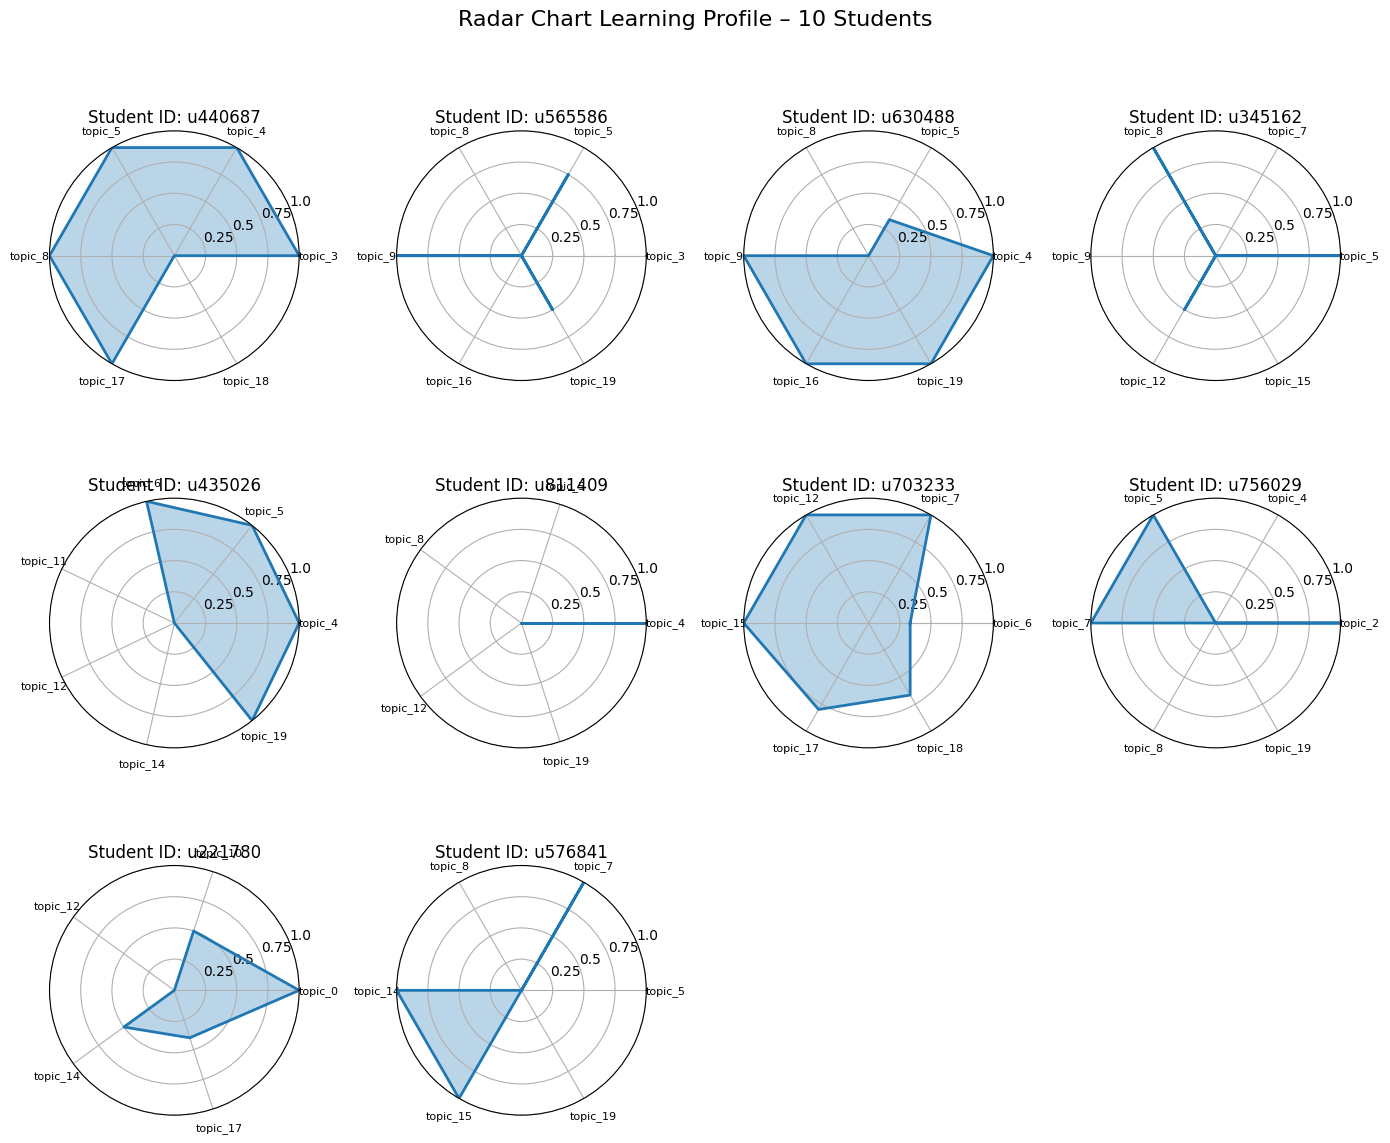

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
# matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)
matriks = pd.read_csv("user_topic_matrix.csv", index_col=0)

# Ambil 10 siswa acak dengan ≥5 topik
sampel_10 = matriks.dropna(thresh=5).sample(10, random_state=42)

# Setup subplot grid: 2 kolom × 5 baris
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), subplot_kw=dict(polar=True))
axs = axs.flatten()

# Plot radar chart untuk tiap siswa
for i, (user_id, row) in enumerate(sampel_10.iterrows()):
    scores = row.dropna().values.tolist()
    labels = row.dropna().index.tolist()

    if len(scores) < 3:
        continue  # Skip siswa yang datanya kurang

    # Persiapkan data
    scores += [scores[0]]  # untuk menutup lingkaran
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    # Radar plot di subplot
    ax = axs[i]
    ax.plot(angles, scores, linewidth=2)
    ax.fill(angles, scores, alpha=0.3)
    ax.set_title(f"Student ID: {user_id}", fontsize=12)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'])
    ax.set_ylim(0, 1)

# Bersihkan sisa subplot jika <10 siswa valid
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Radar Chart Learning Profile – 10 Students", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Simpan gambar ke file (misalnya PNG)
plt.savefig("Radar_chart(Learning_Profile).png", dpi=300)
plt.show()


## 10. Rekomendasi Pembelajaran Adaptif

In [36]:
import pandas as pd

# Load matriks performa
# matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)
matriks = pd.read_csv("user_topic_matrix.csv", index_col=0)

# Threshold akurasi: topik dianggap lemah jika < 0.5
def rekomendasi_topik(row, threshold=0.5):
    lemah = row[row < threshold].dropna()
    return list(lemah.index)

# Buat DataFrame hasil rekomendasi
rekomendasi = matriks.apply(lambda row: rekomendasi_topik(row), axis=1)
rekomendasi_df = pd.DataFrame({
    'user_id': rekomendasi.index,
    'topik_direkomendasikan': rekomendasi.values
})

# Simpan ke file
# rekomendasi_df.to_csv("rekomendasi_pembelajaran_adaptif.csv", index=False)
rekomendasi_df.to_csv("adaptive_learning_recommendations.csv", index=False)

# Lihat contoh
rekomendasi_df.head()


,user_id,topik_direkomendasikan
0,u100580,"[topic_4, topic_5, topic_6, topic_8, topic_9, ..."
1,u101409,"[topic_4, topic_9, topic_10, topic_11, topic_1..."
2,u102852,"[topic_1, topic_5, topic_11, topic_12, topic_1..."
3,u106217,[]
4,u106643,"[topic_0, topic_11, topic_14]"


<ipython-input-38-663516993>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topik_df.head(10), x='jumlah_siswa', y='topik', palette='Reds_r')


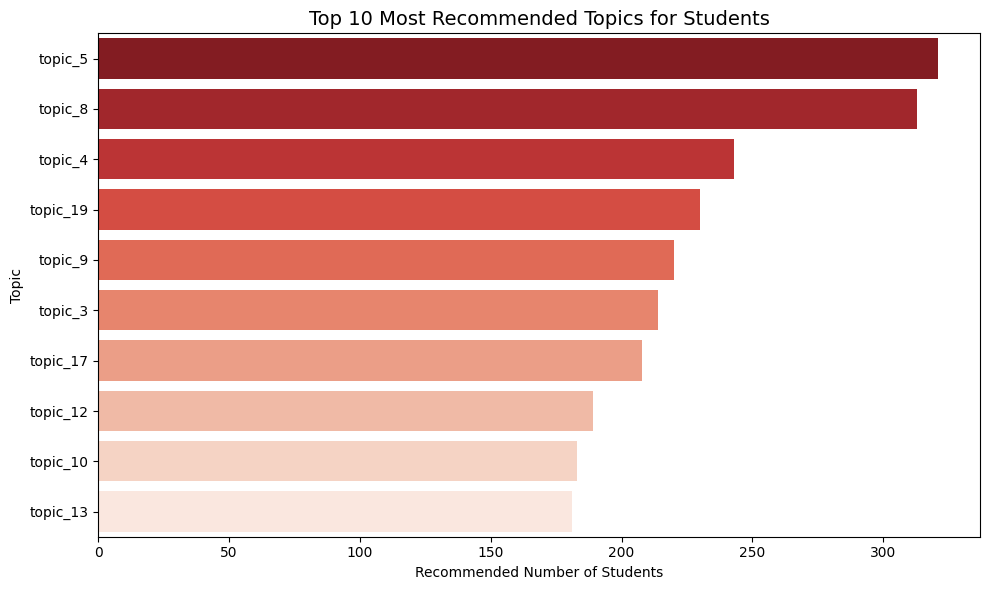

In [38]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil rekomendasi
# rekom_df = pd.read_csv("rekomendasi_pembelajaran_adaptif.csv")
rekom_df = pd.read_csv("adaptive_learning_recommendations.csv")

# Ubah string list ke list Python asli
rekom_df['topik_direkomendasikan'] = rekom_df['topik_direkomendasikan'].apply(eval)

# Gabungkan semua list jadi satu list besar
all_topik = sum(rekom_df['topik_direkomendasikan'].tolist(), [])

# Hitung frekuensi topik
topik_counter = Counter(all_topik)
topik_df = pd.DataFrame(topik_counter.items(), columns=['topik', 'jumlah_siswa'])

# Urutkan topik berdasarkan jumlah siswa yang direkomendasikan
topik_df = topik_df.sort_values(by='jumlah_siswa', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=topik_df.head(10), x='jumlah_siswa', y='topik', palette='Reds_r')
plt.title("Top 10 Most Recommended Topics for Students", fontsize=14)
plt.xlabel("Recommended Number of Students")
plt.ylabel("Topic")
plt.tight_layout()

# Simpan gambar ke file (misalnya PNG)
plt.savefig("Top10_Recommend_Topic.png", dpi=300)
plt.show()



# **Evaluasi Clustering**

In [39]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    sil_score = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)

    print(f"K = {k}: Silhouette = {sil_score:.3f}, DBI = {dbi:.2f}, CH Index = {ch_score:.1f}")

K = 2: Silhouette = 0.296, DBI = 1.41, CH Index = 367.4
K = 3: Silhouette = 0.204, DBI = 2.62, CH Index = 228.2
K = 4: Silhouette = 0.197, DBI = 2.78, CH Index = 168.1
K = 5: Silhouette = 0.136, DBI = 2.70, CH Index = 141.8
K = 6: Silhouette = 0.129, DBI = 2.63, CH Index = 123.0


# **VARK (*Konseptual*)**

In [ ]:
import pandas as pd

# Load matriks user × topik
# df = pd.read_csv("matriks_user_topik.csv", index_col=0)
df = pd.read_csv("student_topic_matrix.csv", index_col=0)

# Buat mapping topik ke kategori VARK
topik_to_vark = {
    'topik_0': 'visual', 'topik_1': 'reading', 'topik_2': 'kinesthetic', 'topik_3': 'auditory',
    'topik_4': 'visual', 'topik_5': 'reading', 'topik_6': 'auditory', 'topik_7': 'kinesthetic',
    'topik_8': 'visual', 'topik_9': 'reading', 'topik_10': 'kinesthetic', 'topik_11': 'auditory',
    'topik_12': 'visual', 'topik_13': 'reading', 'topik_14': 'auditory', 'topik_15': 'kinesthetic',
    'topik_16': 'visual', 'topik_17': 'reading', 'topik_18': 'auditory', 'topik_19': 'kinesthetic'
}

# Transpose dan melt untuk long format
df_long = df.reset_index().melt(id_vars='user_id', var_name='topik', value_name='akurasi')

# Tambah kategori VARK
df_long['vark'] = df_long['topik'].map(topik_to_vark)

# Hapus yang tidak ada mapping atau NaN akurasi
df_long = df_long.dropna(subset=['vark', 'akurasi'])

# Hitung rata-rata akurasi per user_id × VARK
vark_scores = df_long.groupby(['user_id', 'vark'])['akurasi'].mean().unstack().fillna(0)

# Tentukan gaya dominan
vark_scores['vark_dominan'] = vark_scores[['visual', 'auditory', 'reading', 'kinesthetic']].idxmax(axis=1)

# Simpan hasil
# vark_scores.to_csv("estimasi_gaya_belajar_vark.csv")
vark_scores.to_csv("estimated_learning_style_vark.csv")

# Tampilkan contoh
vark_scores.head()


vark,auditory,kinesthetic,reading,visual,vark_dominan
user_id,,,,,
u100580,0.225000,0.458333,0.200000,0.208333,kinesthetic
u101409,0.333333,0.583333,0.680000,0.333333,reading
u102852,0.333333,0.500000,0.520000,0.583333,visual
u106217,0.500000,0.000000,0.000000,1.000000,visual
u106643,0.500000,0.893333,0.933333,0.656250,reading


**Coherence Score Tiap Topik**

In [ ]:
# Error
from gensim.models import CoherenceModel

# Ambil semua topik dari model
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

# Buat daftar kata per topik
topic_words = [[word for word, prob in topic[1]] for topic in topics]

# Hitung coherence untuk masing-masing topik
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=soal_text_df['tokens'],
    dictionary=dictionary,
    coherence='c_v'
)
topic_coherences = coherence_model.get_coherence_per_topic()

# Tampilkan coherence per topik
for i, c in enumerate(topic_coherences):
    print(f"Topik {i}: Coherence = {c:.4f}")


Topik 0: Coherence = 0.4265
Topik 1: Coherence = 0.4084
Topik 2: Coherence = 0.5700
Topik 3: Coherence = 0.5672
Topik 4: Coherence = 0.6868
Topik 5: Coherence = 0.5083
Topik 6: Coherence = 0.3976
Topik 7: Coherence = 0.5249
Topik 8: Coherence = 0.6751
Topik 9: Coherence = 0.6706
Topik 10: Coherence = 0.4464
Topik 11: Coherence = 0.3096
Topik 12: Coherence = 0.3545
Topik 13: Coherence = 0.6805
Topik 14: Coherence = 0.4927
Topik 15: Coherence = 0.5170
Topik 16: Coherence = 0.6799
Topik 17: Coherence = 0.4140
Topik 18: Coherence = 0.4408
Topik 19: Coherence = 0.6665


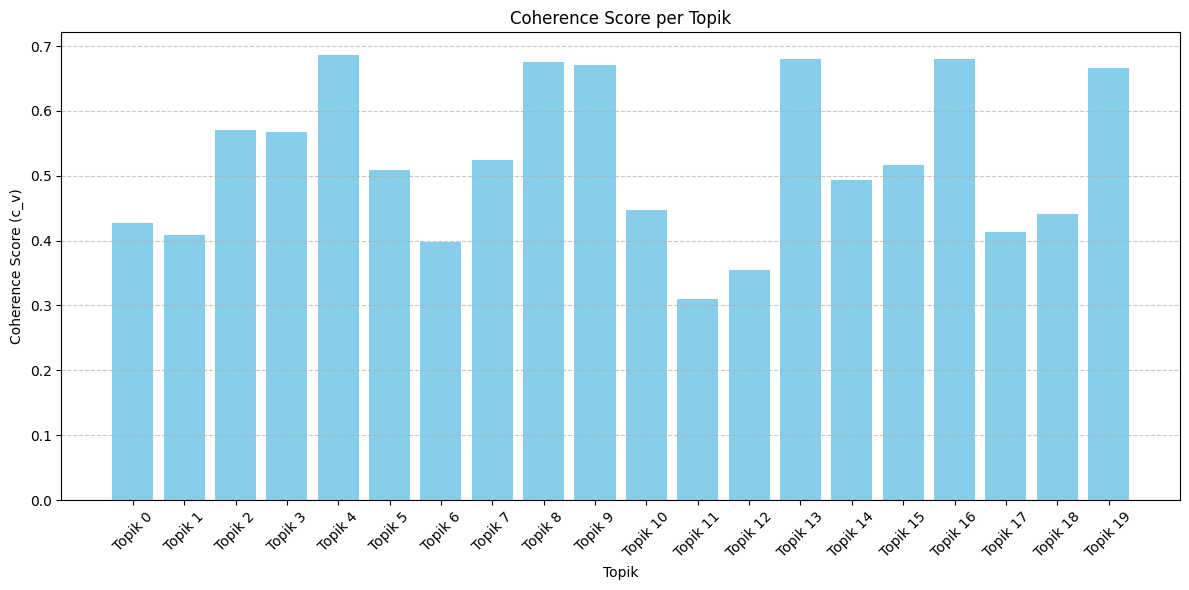

In [ ]:
# Error
import matplotlib.pyplot as plt

# Asumsikan topic_coherences sudah dihitung dari CoherenceModel sebelumnya
# Misalnya:
# topic_coherences = coherence_model.get_coherence_per_topic()

# Buat grafik bar
plt.figure(figsize=(12, 6))
plt.bar(range(len(topic_coherences)), topic_coherences, color='skyblue')
plt.xlabel('Topik')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score per Topik')
plt.xticks(range(len(topic_coherences)), [f'Topik {i}' for i in range(len(topic_coherences))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## **Evaluasi**

In [ ]:
Evaluasi Numerik

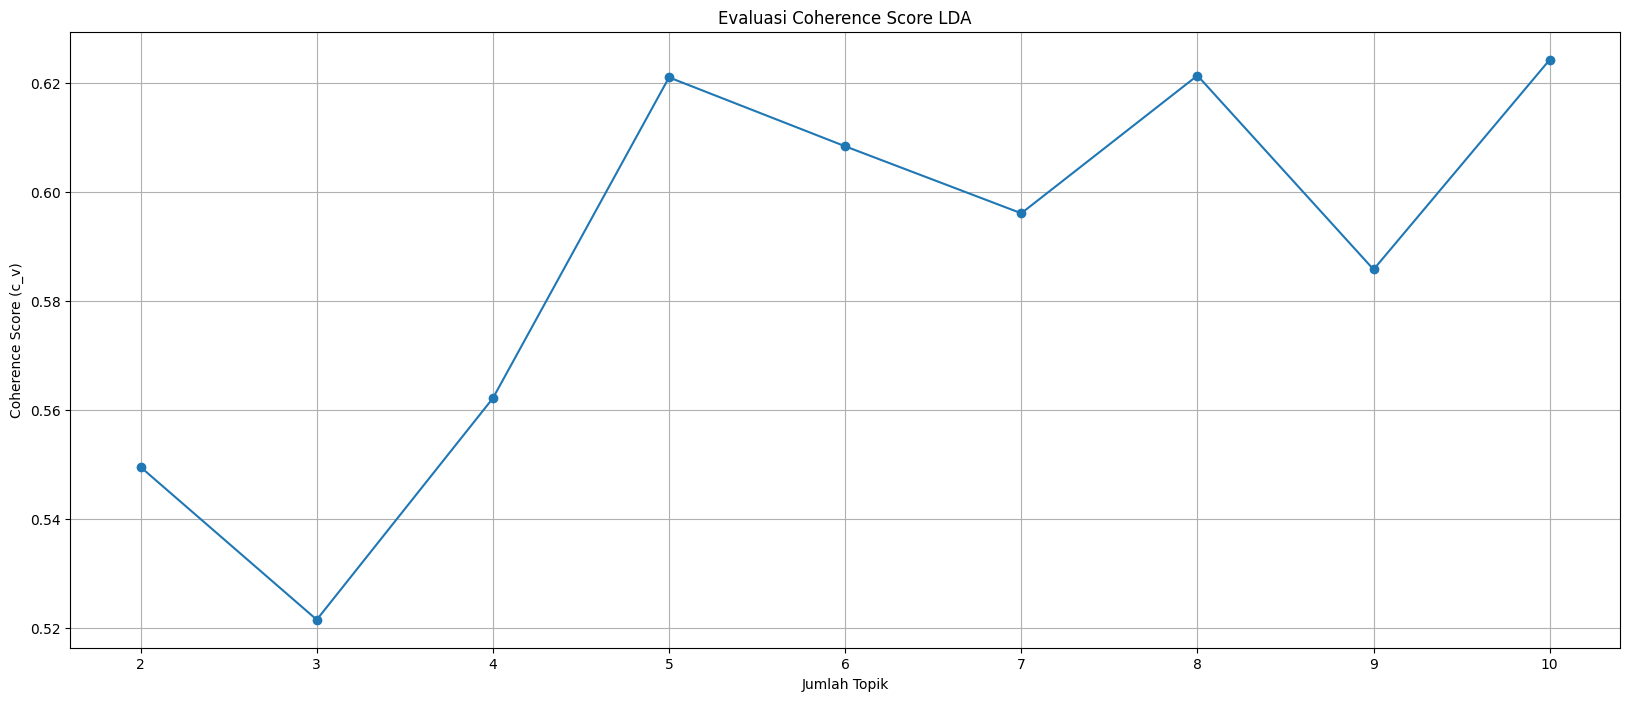

In [ ]:
import pandas as pd
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Baca file hasil pseudo-teks soal
# soal_text_df = pd.read_csv("soal_pseudo_text.csv")
soal_text_df = pd.read_csv("pseudotext_soal.csv")

# Tokenisasi teks
texts = soal_text_df['Pseudoteks (clean_text)'].apply(lambda x: x.split()).tolist()

# Buat dictionary dan corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Fungsi evaluasi dan visualisasi coherence score
def evaluate_coherence(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        model = models.LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                random_state=42,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # Visualisasi
    x = range(start, limit + 1, step)
    plt.figure(figsize=(20, 8))
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel("Jumlah Topik")
    plt.ylabel("Coherence Score (c_v)")
    plt.title("Evaluasi Coherence Score LDA")
    plt.xticks(x)
    plt.grid(True)
    plt.show()

    return model_list, coherence_values

# Jalankan evaluasi
model_list, coherence_values = evaluate_coherence(dictionary, corpus, texts, start=2, limit=10, step=1)


In [ ]:
merged_df = interaksi_df.merge(soal_df, on="question_id", how="left")


In [ ]:
from gensim.utils import simple_preprocess
tokenized_texts = [simple_preprocess(text) for text in merged_df["clean_text"].fillna("")]


KeyError: 'clean_text'

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=1, no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]


NameError: name 'tokenized_texts' is not defined

In [ ]:
from gensim.models import LdaModel
lda_model = LdaModel(corpus, num_topics=20, id2word=dictionary, passes=10)

def get_topic_distribution(bow):
    return [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]

topic_distributions = [get_topic_distribution(bow) for bow in corpus]


In [ ]:
import pandas as pd
topic_df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(20)])
model_df = pd.concat([merged_df.reset_index(drop=True), topic_df], axis=1)


In [ ]:
model_df["label"] = (model_df["user_answer"] == model_df["correct_answer"]).astype(int)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = model_df[[f"topic_{i}" for i in range(20)]]
y = model_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Evaluasi Clustering

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    sil_score = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    ch_score = calinski_harabasz_score(X_scaled, labels)

    print(f"K = {k}: Silhouette = {sil_score:.3f}, DBI = {dbi:.2f}, CH Index = {ch_score:.1f}")


K = 2: Silhouette = 0.296, DBI = 1.41, CH Index = 367.4
K = 3: Silhouette = 0.204, DBI = 2.62, CH Index = 228.2
K = 4: Silhouette = 0.198, DBI = 2.80, CH Index = 167.9
K = 5: Silhouette = 0.136, DBI = 2.70, CH Index = 141.8
K = 6: Silhouette = 0.129, DBI = 2.63, CH Index = 123.0


In [ ]:
import matplotlib.pyplot as plt

topics = ['Topic 1', 'Topic 2', 'Topic 3']
scores = [0.8, 0.6, 0.9]

plt.figure(figsize=(8, 6))
plt.bar(topics, scores, color='skyblue')
plt.title('Topic Recommendation')
plt.ylabel('Score')
plt.savefig('bar_chart_topic_recommendation.png', dpi=300)
plt.close()
